This is a simple Transformer test with the goal to train to predict a sine wave using PyTorch.

In [2]:
# Created by Davide Pasca - 2023/07/27

import torch
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from typing import Tuple

In [4]:
import subprocess
import torch

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    print(subprocess.check_output(["nvidia-smi"], encoding="utf-8").strip())
    print("Torch CUDA version:", torch.version.cuda)
elif torch.backends.mps.is_available():
    device = "mps"

print("Using device:", device)

Using device: mps


In [3]:
USE_LOG_RETURNS = False

TRAIN_SAMPLES_N = 500
TEST_SAMPLES_N = 100

In [4]:
# Generate the sine wave data
train_y = np.sin(np.linspace(0, 4 * np.pi, TRAIN_SAMPLES_N))
train_y += 1.1 # we want > 0 numbers

test_y = np.sin(np.linspace(4 * np.pi, 8 * np.pi, TEST_SAMPLES_N))
test_y += 1.1 # we want > 0 numbers

# Plot the sine wave
#plt.plot(x, y)
#plt.show()

In [5]:
# The sequence length will be the number of time steps that our model will consider for its predictions
sequence_length = 50

def create_sequences(input_data, seq_length):
    """
    Create sequences from the input time series data.
    """
    sequences = []

    if USE_LOG_RETURNS:
        # Compute the log returns. We'll shift the input data by 1 element to compute the difference in logs.
        use_input_data = np.log(input_data[1:]) - np.log(input_data[:-1])
        # Normalize log returns
        use_input_data = (use_input_data - np.mean(use_input_data)) / np.std(use_input_data)
    else:
        use_input_data = (input_data - np.mean(input_data)) / np.std(input_data)

    length = len(use_input_data)

    for i in range(length - seq_length):
        seq = use_input_data[i:i + seq_length]
        label = use_input_data[i + seq_length]
        sequences.append((seq, label))

    return sequences

# Create the sequences
train_sequences = create_sequences(train_y, sequence_length)
test_sequences = create_sequences(test_y, sequence_length)

# Convert sequences to numpy arrays first, then to PyTorch tensors
train_sequence_data = [
    (torch.from_numpy(np.array(seq)).unsqueeze(1).float().to(device),
     torch.tensor(label).float().to(device))
    for seq, label in train_sequences]

test_sequence_data = [
    (torch.from_numpy(np.array(seq)).unsqueeze(1).float().to(device),
        torch.tensor(label).float().to(device))
    for seq, label in test_sequences]


In [6]:
train_data = train_sequence_data
test_data = test_sequence_data

In [7]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, seq_len=50, num_layers=2, hidden_dim=128):
        super(TransformerModel, self).__init__()
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=1,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Transform the input sequence using the embedding layer.
        # This converts each input value into a dense vector of size 'hidden_dim'.
        x = self.embedding(x)
        # Shift the input sequence one step to the right to create the target sequence.
        # Zero-pad the shifted sequence at the beginning to maintain the same length.
        tgt = torch.cat(
            [torch.zeros(1, 1, self.hidden_dim, device=device),
                x[:-1,:,:]], # Exclude last sequence from x
                dim=0)
        x = self.transformer(x, tgt)
        x = self.fc(x) # Apply last layer, hidden_dim -> output_dim
        return x

model = TransformerModel()
model = model.to(device)

In [8]:
def print_report(epoch, epochs, train_losses, target_losses, test_data, test_predictions):
    # Plot losses and predictions
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

    # Plot losses
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(target_losses, label='Target Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot the actual values and the predictions
    axs[1].plot([label.item() for _, label in test_data], label='Actual')
    axs[1].plot(test_predictions, label='Predicted')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('Normalized Value')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()

    clear_output(wait=True)
    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Train loss: {train_losses[-1]:.4f}')
    print(f'Target loss: {target_losses[-1]:.4f}')
    plt.show()

Epoch 100/100
Train loss: 0.0055
Target loss: 1.6571


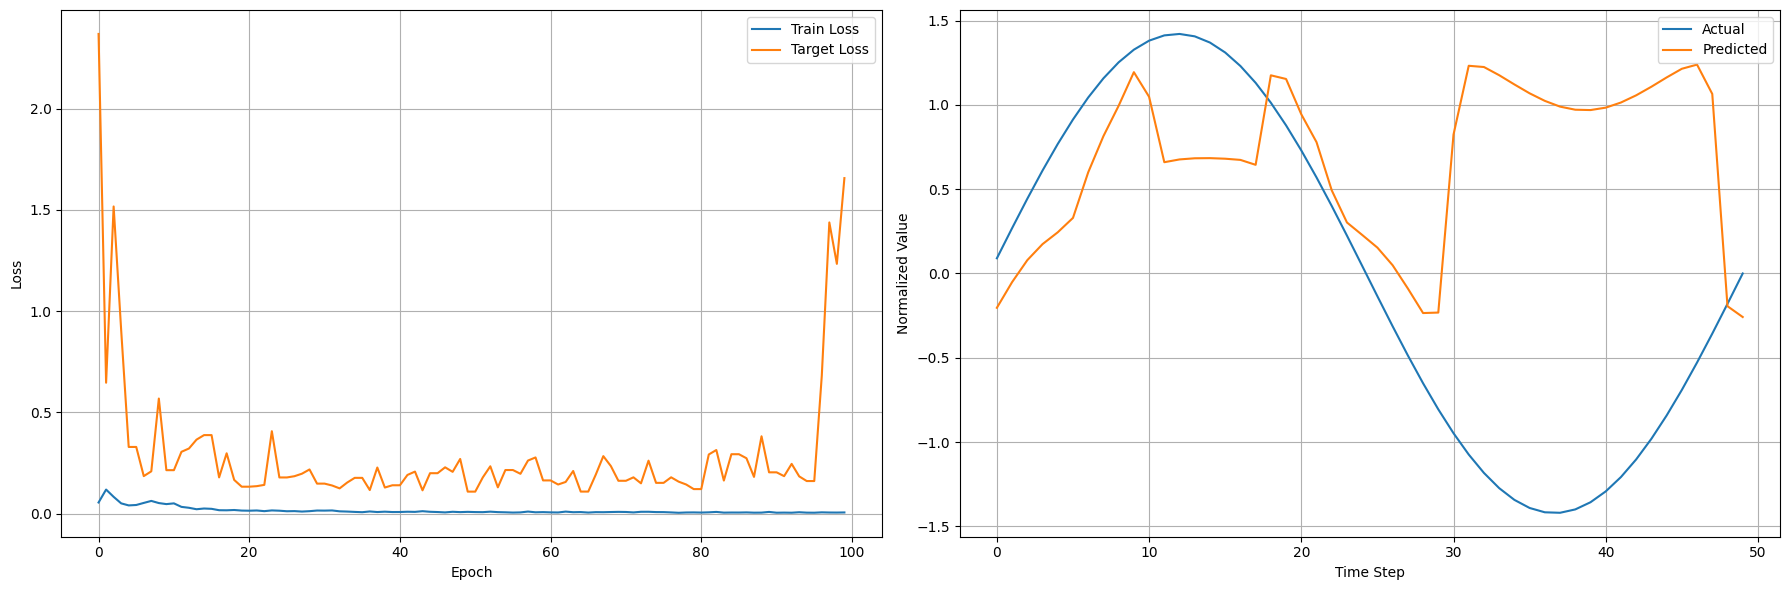

In [9]:
# torch seed to 0
torch.manual_seed(0)

# Define loss function and optimizer
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Number of epochs
epochs = 100

# For storing losses
train_losses = []
target_losses = []

# For plotting losses
plt.ion()

last_update_time = time.time()

for epoch in range(epochs):
    train_loss = 0.0
    for seq, label in train_data:
        optimizer.zero_grad() # Reset the gradients
        seq = seq.unsqueeze(1) # Add batch dimension
        output = model(seq).squeeze() # Forward pass

        # Compute the loss, and sum the losses over the batch
        loss = criterion(output[-1], label.squeeze())
        train_loss += loss.item()

        loss.backward() # Backward pass
        optimizer.step() # Update the weights

    # Average training loss for this epoch
    train_loss /= len(train_data)
    train_losses.append(train_loss)

    is_edge_epoch = (epoch == 0 or epoch == epochs - 1)

    # Compute loss on target data
    if is_edge_epoch or (epoch % 5):
      target_loss = 0
      for seq, label in test_data:
          seq = seq.unsqueeze(1)
          output = model(seq).squeeze()
          target_loss += criterion(output[-1], label.squeeze()).item()
      target_loss /= len(test_data)
      target_losses.append(target_loss)
    else:
      # append the previous target loss
      target_losses.append(target_losses[-1])

    # Print losses
    if time.time() > (last_update_time+5) or is_edge_epoch:
        model.eval()
        # Generate predictions on the test set
        test_predictions = []
        for seq, label in test_data:
            seq = seq.unsqueeze(1)
            output = model(seq)
            test_predictions.append(output[-1].item())
        model.train()

        print_report(epoch, epochs, train_losses, target_losses, test_data, test_predictions)

plt.ioff()